# 3D non-linear System
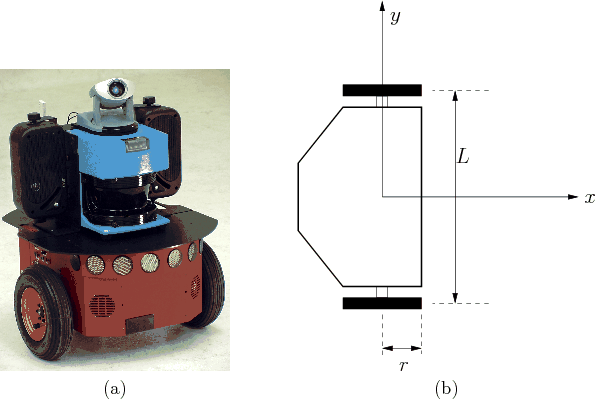
###Dynamics: 
$$   \boldsymbol {\dot x} =f(\boldsymbol{x},\boldsymbol{u}) = f(\boldsymbol x)+g(\boldsymbol x)\boldsymbol u= \begin{bmatrix} 0 &0 &0 \\0&0 &0\\0&0 &0 \end{bmatrix}\begin{bmatrix} x\\y\ \\ \theta \end{bmatrix} + \begin{bmatrix} \cos \theta & 0\\ \sin θ & 0\\0 & 1\end{bmatrix}\begin{bmatrix} v\\ \dot \theta\end{bmatrix} \quad :\boldsymbol x \in \mathbb{R}^3, \boldsymbol u \in \mathbb{R}^2$$

###Optimal Control problem (finite horizon with terminal cost): 
$$\min_{u} \mathcal{L} = \boldsymbol x(t_f)^T \boldsymbol M \boldsymbol x(t_f) + \int_{0}^{t_f}(\boldsymbol x^T\boldsymbol Q \boldsymbol x+\boldsymbol u^T\boldsymbol R \boldsymbol u )dt \quad\text{   where  } \quad t_f=1, \boldsymbol Q =\boldsymbol I_{3 \times 3}, \boldsymbol R= \boldsymbol I_{2 \times 2}, \boldsymbol M= \boldsymbol I_{3 \times 3}$$

### HJB equation:
$$ V_t = \sup_\boldsymbol u -H(\boldsymbol x,V_x, \boldsymbol u,t) = \sup_\boldsymbol u \{-(\nabla_\boldsymbol x V)^Tf(\boldsymbol x,\boldsymbol u) - \boldsymbol x^T\boldsymbol Q \boldsymbol x-\boldsymbol u^T\boldsymbol R \boldsymbol u \} $$

$$ \boldsymbol u_{opt} = -\frac{1}{2}\boldsymbol R^{-1} g^T(\boldsymbol x)\nabla_\boldsymbol x V$$

Resulting PDE to solve:
$$-V_t- \boldsymbol x^T\boldsymbol Q \boldsymbol x + \frac{1}{4}(\nabla_\boldsymbol x V)^T g(\boldsymbol x)\boldsymbol R^{-1} g^T(\boldsymbol x)(\nabla_\boldsymbol x V) = 0 \quad  $$
Subject to: $$V(1,\boldsymbol x) = \boldsymbol x^T M \boldsymbol x \quad \forall \boldsymbol x:  \begin{bmatrix} x&y& \theta \end{bmatrix}^T $$
state space domain:
$$ t \in [0,1] x \in [-1,1], y \in [-1,1], \theta \in[-\pi,\pi]$$



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from functools import partial

In [2]:
class ffnn(nn.Module):
    """basic FF network for approximating functions"""
    def __init__(self, nn_width=10, num_hidden=3):
        super().__init__()
        
        self.layer_first = nn.Linear(4, nn_width)
        
        layers = []
        for _ in range(num_hidden):
            layers.append(nn.Linear(nn_width, nn_width))
        self.layer_hidden = nn.ModuleList(layers)
        
        self.layer_last = nn.Linear(nn_width, 1)
        
    def forward(self, x):
        activation = nn.Tanh()
        u = activation(self.layer_first(x))
        for hidden in self.layer_hidden:
            u = activation(hidden(u))
        u = self.layer_last(u)
        return u

In [3]:
t1d=torch.linspace(0,1,25,requires_grad=True)
x1d=torch.linspace(-1,1,25,requires_grad=True)
y1d=torch.linspace(-1,1,25,requires_grad=True)
th1d=torch.linspace(-3.141,3.141,25,requires_grad=True)

tgrid, xgrid, ygrid, thgrid = torch.meshgrid(t1d, x1d, y1d, th1d, indexing ='ij')

t=tgrid.flatten().unsqueeze(-1)
x=xgrid.flatten().unsqueeze(-1)
y=ygrid.flatten().unsqueeze(-1)
th=thgrid.flatten().unsqueeze(-1)

in_vec = torch.hstack((t,x,y,th))
t_bou = torch.ones((in_vec.shape[0],1),requires_grad=True)

# 2. set the model
torch.manual_seed(23939)
model = ffnn(15, 3)

# 3. set the optimizer
lr = 0.002
opt = torch.optim.Adam(model.parameters(), lr)
n_epochs = 50000
mse_loss = nn.MSELoss()
loss_history = []


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
in_vec = in_vec.to(device)
t_bou = t_bou.to(device)
model = model.to(device)

In [5]:
def loss_function(model, in_vec,t_bou):
  v=model(in_vec)
  v_x_1= model(torch.hstack((t_bou,in_vec[:,1:])))

  loss_v_1= mse_loss(v_x_1, torch.sum(torch.square(in_vec[:,1:]),axis =1).unsqueeze(-1))
  
  v_X = torch.autograd.grad(v, in_vec,grad_outputs=t_bou,retain_graph=True,create_graph=True)[0]

  r= -v_X[:,0].view(-1,1) - torch.sum(torch.square(in_vec[:,1:]),axis =1).view(-1,1) + 0.25* torch.square(v_X[:,1].view(-1,1)*torch.cos(in_vec[:,3]).view(-1,1)+
          v_X[:,2].view(-1,1)*torch.sin(in_vec[:,3]).view(-1,1) ) +0.25 *torch.square(v_X[:,3].view(-1,1))
  loss_r = (r**2).mean()
  loss_value = loss_v_1 + loss_r

  return loss_value

In [6]:
for i in range(n_epochs):
  loss=loss_function(model, in_vec, t_bou)
  opt.zero_grad()
  loss_history.append(loss.item())
  loss.backward()
  opt.step()
  if i % 1000 == 0:
    print(f'epoch {i}, loss = {loss}')

epoch 0, loss = 56.8593864440918
epoch 1000, loss = 0.4251556098461151
epoch 2000, loss = 0.2638011574745178
epoch 3000, loss = 0.22153660655021667
epoch 4000, loss = 0.2181689590215683
epoch 5000, loss = 0.21666279435157776
epoch 6000, loss = 0.21572339534759521
epoch 7000, loss = 0.21488717198371887
epoch 8000, loss = 0.2144503891468048
epoch 9000, loss = 0.05170993506908417
epoch 10000, loss = 0.041808173060417175
epoch 11000, loss = 0.03638092055916786
epoch 12000, loss = 0.032912157475948334
epoch 13000, loss = 0.029655521735548973
epoch 14000, loss = 0.0274142324924469
epoch 15000, loss = 0.028258301317691803
epoch 16000, loss = 0.023524723947048187
epoch 17000, loss = 0.02025468647480011
epoch 18000, loss = 0.03333844989538193
epoch 19000, loss = 0.017828237265348434
epoch 20000, loss = 0.015754349529743195
epoch 21000, loss = 0.014076413586735725
epoch 22000, loss = 0.01267913542687893
epoch 23000, loss = 0.022373169660568237
epoch 24000, loss = 0.010485798120498657
epoch 25000

In [7]:
torch.save(model.state_dict(), "diff_drive_mod.pth")
torch.save(loss_history, "loss_history.pt")

# Plot the solution

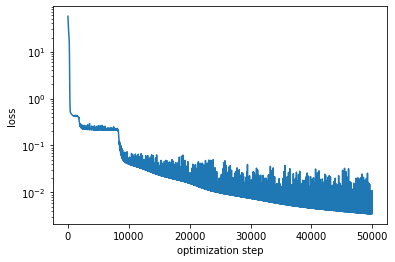

In [8]:
plt.plot(loss_history)
plt.xlabel('optimization step')
plt.ylabel('loss');
plt.yscale('log')

In [9]:
model = ffnn(15,3)
model.load_state_dict(torch.load('diff_drive_mod.pth',map_location='cpu'))
model.eval()

ffnn(
  (layer_first): Linear(in_features=4, out_features=15, bias=True)
  (layer_hidden): ModuleList(
    (0): Linear(in_features=15, out_features=15, bias=True)
    (1): Linear(in_features=15, out_features=15, bias=True)
    (2): Linear(in_features=15, out_features=15, bias=True)
  )
  (layer_last): Linear(in_features=15, out_features=1, bias=True)
)

In [10]:
def u(model,x):
  ######## x is N=1
  v=model(x)
  temp = torch.ones((x.shape[0],1),requires_grad=True)
  v_x = torch.autograd.grad(v,x,grad_outputs=temp,retain_graph=True,create_graph=True)[0]
  v_x = v_x[:,1:]
  u = v_x[:,0]*torch.cos(x[:,3])+ v_x[:,1]*torch.sin(x[:,3])
  u =torch.hstack((u,v_x[:,2]))


  return -0.5*u.t()


In [11]:
x_init= torch.tensor([0,1,3.141/2],requires_grad=True).unsqueeze(-1)
t1d=torch.linspace(0,1,20,requires_grad=True)

x=x_init
states=[x.detach().numpy().squeeze()]
controls =[]
dt = (t1d[1]-t1d[0]).detach()
for t in t1d:
  in_vec = torch.vstack((t.view(1,1),x)).t()
  u_opt = u(model, in_vec )
  del_x=  torch.tensor([[torch.cos(x[2]),0],[torch.sin(x[2]),0],[0,1]]) @ u_opt
  del_x = del_x.view(x.shape)
  x=x + del_x*dt
  states.append(x.detach().numpy().squeeze())
  controls.append(u_opt.detach().numpy().squeeze())



In [12]:
states = np.asarray(states)
controls = np.asarray(controls)
t1d=t1d.requires_grad_(requires_grad=False).numpy()
t1d = np.append(t1d,t1d[-1])

controls = np.vstack((controls, np.array([0,0])))
controls.shape

(21, 2)

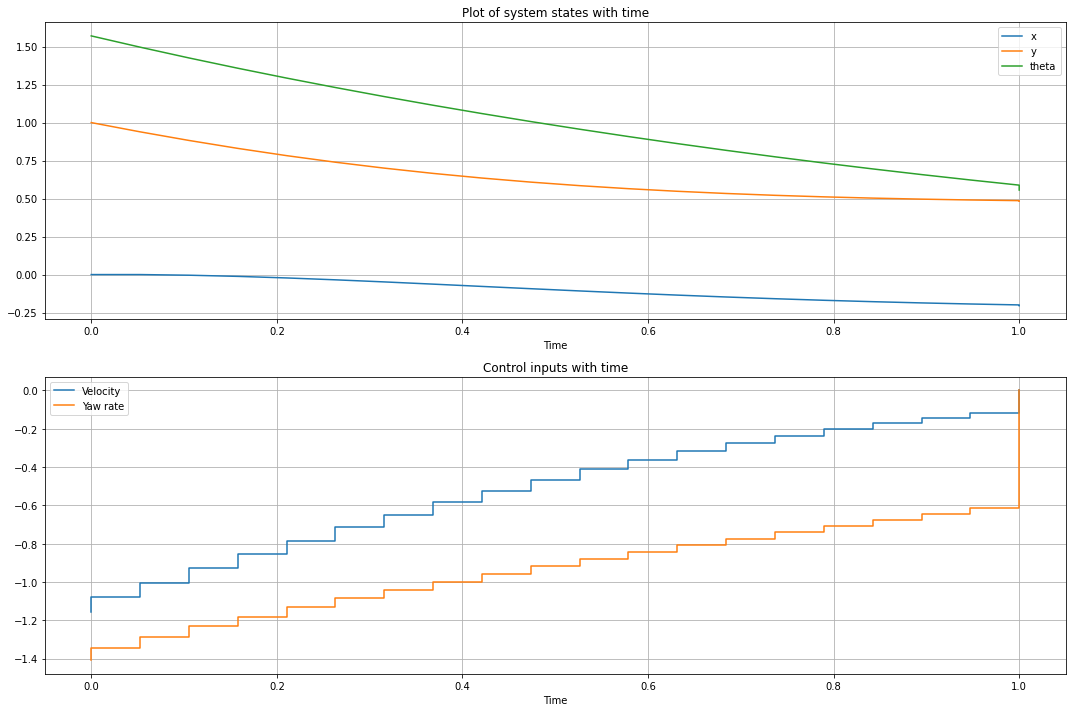

In [13]:
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
#plt.clf()
plt.plot(t1d, states[:,0])
plt.plot(t1d, states[:,1])
plt.plot(t1d, states[:,2])
plt.grid()
plt.title('Plot of system states with time')
plt.xlabel('Time')
plt.legend(['x','y','theta'])
#plt.savefig("Canvas12.png",dpi=500)

plt.subplot(2, 1, 2)
#plt.clf()
plt.step(t1d, controls[:,0])
plt.step(t1d, controls[:,1])
plt.grid()
plt.xlabel('Time')
plt.title('Control inputs with time')
plt.legend(['Velocity','Yaw rate'])
#plt.savefig("Canvas13.png",dpi=500)
plt.tight_layout()
plt.show()

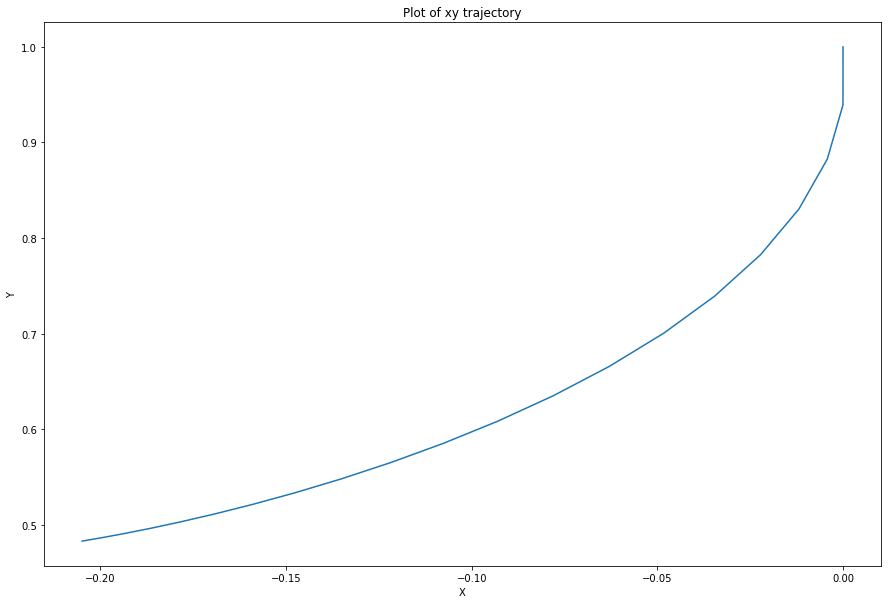

In [14]:
plt.figure(figsize=(15,10))
plt.plot(states[:,0],states[:,1])
plt.title('Plot of xy trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()